# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 



---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2
import numpy as np
from scipy.ndimage import zoom
from scipy.ndimage import rotate
import matplotlib
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec

In [2]:
import tensorflow as tf

print(tf.__version__)
if tf.test.gpu_device_name():

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

2.3.0
Default GPU Device:/device:GPU:0


In [3]:

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples= ",n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples=  4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

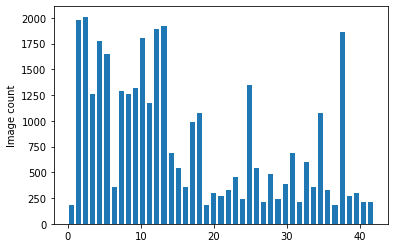

In [5]:
hist, bins = np.histogram(y_train, bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=0.7)
plt.ylabel("Image count")
plt.show()


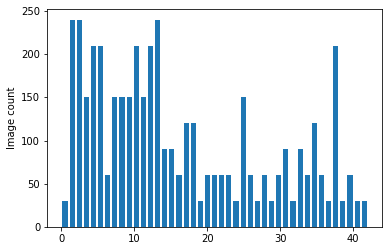

In [6]:
hist, bins = np.histogram(y_valid,bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=0.7)
plt.ylabel("Image count")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
# new data set creation can be seen on the last part of this notebook

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def get_gray(image_data):
    final = np.sum(image_data/3, axis=3, keepdims=True)
    return final
def hsv(image_data):
    norm_list = []
    for image in image_data:

        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        hsv[:,:,2] += 10

        img= cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        norm_list.append(img)
    np_list = np.array(norm_list)
    return np_list


def cv2_clipped_zoom(img, zoom):

    height, width = img.shape[:2] 
    new_height, new_width = int(height * zoom), int(width * zoom)
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    
    bbox = np.array([y1,x1,y2,x2])
    bbox = (bbox / zoom).astype(np.int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    result = cv2.resize(cropped_img, (resize_width, resize_height))

    assert result.shape[0] == height and result.shape[1] == width
    return result
def create_pictures(img):
    zm1 = cv2_clipped_zoom(img, 1.05)
    
    M = np.float32([[1, 0, -3], [0, 1, 3]]) 
    M2 = np.float32([[1, 0, 3], [0, 1, 3]]) 
    (rows, cols) = img.shape[:2] 
  
    sh1 = cv2.warpAffine(img, M, (cols, rows)) 
    zm2 = cv2_clipped_zoom(sh1,1.05)
    sh2 = cv2.warpAffine(img, M2,(cols, rows))
    zm3 = cv2_clipped_zoom(sh2,1.05)
    return zm1,sh1,zm2,sh2,zm3

In [8]:
def randPlot(X,Y):
    plt.figure(figsize = (20,15))
    grid = gridspec.GridSpec(5,5)
    grid.update(wspace=0.02, hspace=0.2)
    for i in range(5*5):
        ax1 = plt.subplot(grid[i])
        ind_plot = np.random.randint(1,len(Y))
        plt.imshow(X[ind_plot])
        sign_number=(Y[ind_plot])
        plt.title(signs[sign_number])
        plt.axis('off')
    plt.show()

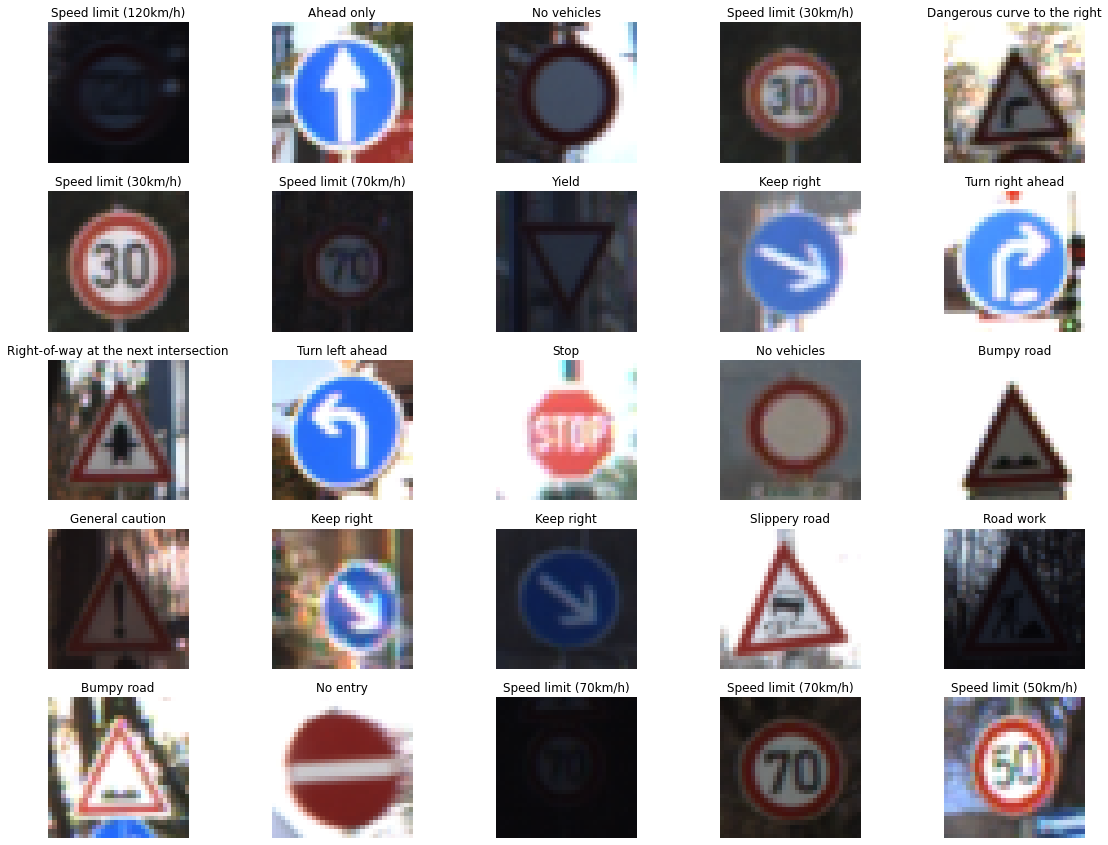

In [9]:
randPlot(X_valid,y_valid)

# Load augmented data to save time

In [10]:

filename = 'new_x_train_data_5.p'
infile = open(filename,'rb')
X_train = pickle.load(infile)
infile.close()
filename = 'new_y_train_data_5.p'
infile = open(filename,'rb')
y_train = pickle.load(infile)
infile.close()
filename = 'new_x_valid_data_5.p'
infile = open(filename,'rb')
X_valid = pickle.load(infile)
infile.close()
filename = 'new_y_valid_data_5.p'
infile = open(filename,'rb')
y_valid = pickle.load(infile)
infile.close()



In [11]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples= ",n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 76100
Number of testing examples = 12630
Number of validation examples=  9295
Image data shape = (32, 32, 3)
Number of classes = 43


# Check how the new dataset looks like

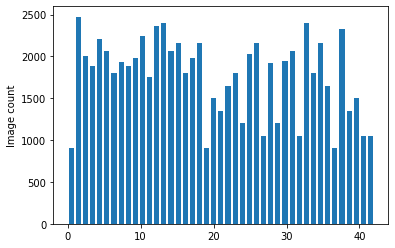

In [12]:
hist, bins = np.histogram(y_train, bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2
from numpy import mean
plt.bar(center, hist, align='center', width=0.7)
plt.ylabel("Image count")
plt.show()


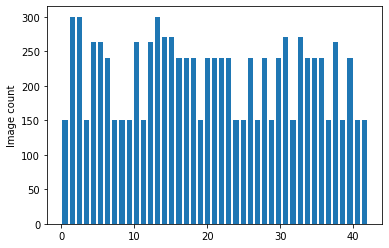

In [13]:
hist, bins = np.histogram(y_valid,bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2
from numpy import mean
plt.bar(center, hist, align='center', width=0.7)
plt.ylabel("Image count")
plt.show()

In [14]:
normalized = ((X_train)*0.8/255) + 0.1
X_train = normalized
normalized = ((X_valid)*0.8/255) + 0.1
X_valid = normalized
normalized = ((X_test)*0.8/255) + 0.1
X_test = normalized

In [15]:
EPOCHS = 70
BATCH_SIZE = 128
DROPOUT = np.float64(0.7)
BETA=5e-4

### Model Architecture

In [16]:

#from tf.compat.v1.layers.flatten import flatten
#tf.compat.v1.disable_eager_execution()
def LeNet(x,keep_prob):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    #keep_prob = 0.5
    prob = keep_prob
    sigma = 0.1
    # 6 filters needed. => new_height(=28) = ( 32 - filter_height + 2 * Padding ) / S + 1 . => (32-filter_height + 2*padding)/S = 27
    # if S = 1 => 32-filter_height + 2*padding = 27 =>  filter_height -2*padding = 5 => padding = 1 , filter_height = 7
    # (32 - filter_height + 1) / S) = 28 => filter_height = 5 and S = 1 I think is more accurate than with a 7x7 filter
    weight_l1 = tf.Variable(tf.random.truncated_normal(shape = (5,5,3,18),mean = mu, stddev = sigma))
    bias_l1 = tf.Variable(tf.zeros(18))
    strides = [1,1,1,1]
    padding = 'VALID'
    conv1 = tf.nn.conv2d(input=x,filters=weight_l1,strides=strides,padding=padding)+bias_l1
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)
    #print(conv1)
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    # page 20 of lesson 13
    conv1 = tf.nn.max_pool2d(input=conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID',name='conv1')


    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    # Input = 14x14x6 -> Output = 10x10x16
    # (14 - filter_height + 1)/ S = 10 filter_height = 5 S=1
    weight_l2 = tf.Variable(tf.random.truncated_normal(shape=(5,5,6,72),mean = mu,stddev = sigma))
    bias_l2 = tf.Variable(tf.zeros(72))
    strides = [1,1,1,1]
    padding = 'VALID'
    conv2 = tf.nn.conv2d(input=conv1, filters=weight_l2, strides=strides,padding=padding) + bias_l2

    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool2d(input=conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding = 'VALID',name='conv2')
    #conv2_drop = tf.nn.dropout(conv2,0.4)
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    flat = tf.compat.v1.layers.flatten(conv2)
    #print('keep prob',prob,keep_prob)
    flat_drop = tf.nn.dropout(flat,keep_prob)
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.

    weight_l3 = tf.Variable(tf.random.truncated_normal(shape=(1800, 240), mean = mu, stddev = sigma))
    bias_l3 = tf.Variable(tf.zeros(240))
    layer3   = tf.matmul(flat_drop, weight_l3) + bias_l3
    # TODO: Activation.
    layer3 = tf.nn.relu(layer3)
    layer3_drop = tf.nn.dropout(layer3,keep_prob)
    #layer3 = tf.nn.dropout(layer3)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    weight_l4 = tf.Variable(tf.random.truncated_normal(shape=(240, 148), mean = mu, stddev = sigma))
    bias_l4 = tf.Variable(tf.zeros(148))
    layer4   = tf.matmul(layer3, weight_l4) + bias_l4
    # TODO: Activation.
    layer4 = tf.nn.relu(layer4)
    layer4_drop = tf.nn.dropout(layer4,keep_prob)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    weight_l5 = tf.Variable(tf.random.truncated_normal(shape=(148, 43), mean = mu, stddev = sigma))
    bias_l5 = tf.Variable(tf.zeros(43))
    layer5   = tf.matmul(layer4_drop, weight_l5) + bias_l5
    l2 = tf.nn.l2_loss(weight_l1) + tf.nn.l2_loss(weight_l2) + tf.nn.l2_loss(weight_l3) + tf.nn.l2_loss(weight_l4) + tf.nn.l2_loss(weight_l5)
    
    return layer5,l2

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
tf.compat.v1.disable_eager_execution()
keep_prob = tf.compat.v1.placeholder(tf.float32)
x = tf.compat.v1.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.compat.v1.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
rate = 0.0006
keep_prob = tf.compat.v1.placeholder(tf.float32)


In [18]:
logits,l2 = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(one_hot_y), logits=logits) + l2*BETA
loss_operation = tf.reduce_mean(input_tensor=cross_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(input=logits, axis=1), tf.argmax(input=one_hot_y, axis=1))
accuracy_operation = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
saver = tf.compat.v1.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.compat.v1.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [19]:

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_examples = len(X_train)

    print(DROPOUT)
    print(keep_prob)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet_zdrop50')
    print("Model saved")

0.7
Tensor("Placeholder_3:0", dtype=float32)
Training...

EPOCH 1 ...
Train Accuracy = 0.536
Validation Accuracy = 0.449

EPOCH 2 ...
Train Accuracy = 0.745
Validation Accuracy = 0.594

EPOCH 3 ...
Train Accuracy = 0.837
Validation Accuracy = 0.724

EPOCH 4 ...
Train Accuracy = 0.900
Validation Accuracy = 0.795

EPOCH 5 ...
Train Accuracy = 0.931
Validation Accuracy = 0.840

EPOCH 6 ...
Train Accuracy = 0.954
Validation Accuracy = 0.865

EPOCH 7 ...
Train Accuracy = 0.972
Validation Accuracy = 0.883

EPOCH 8 ...
Train Accuracy = 0.976
Validation Accuracy = 0.890

EPOCH 9 ...
Train Accuracy = 0.981
Validation Accuracy = 0.901

EPOCH 10 ...
Train Accuracy = 0.986
Validation Accuracy = 0.912

EPOCH 11 ...
Train Accuracy = 0.988
Validation Accuracy = 0.915

EPOCH 12 ...
Train Accuracy = 0.988
Validation Accuracy = 0.911

EPOCH 13 ...
Train Accuracy = 0.991
Validation Accuracy = 0.908

EPOCH 14 ...
Train Accuracy = 0.994
Validation Accuracy = 0.923

EPOCH 15 ...
Train Accuracy = 0.994
Valid

In [20]:
#17:55 start - 
with tf.compat.v1.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_zdrop50
Test Accuracy = 0.961


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

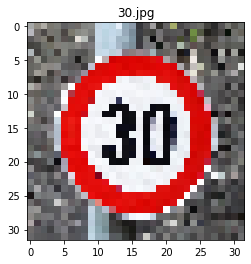

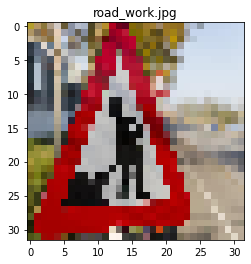

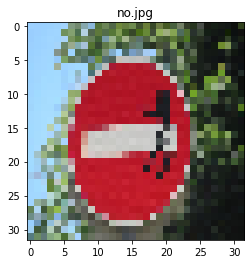

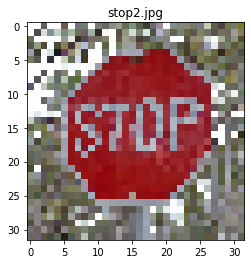

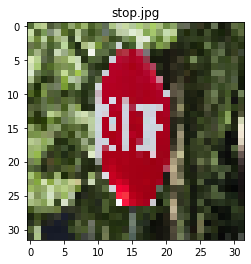

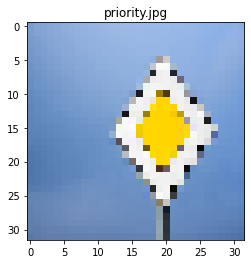

<Figure size 432x288 with 0 Axes>

In [21]:
import os
import matplotlib.image as mpimg
X_test_new = []
X_test_new_name = []
for images in os.listdir("test_img/"):
    image = mpimg.imread('test_img/' + images)
    
    resized = cv2.resize(image,(32,32))
    normalized = ((resized)*0.8/255) + 0.1
    plt.title(images)
    plt.imshow(resized)   
    plt.figure()
    X_test_new.append(normalized)
    X_test_new_name += [images]

### Predict the Sign Type for Each Image

In [22]:
with tf.compat.v1.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))  
    predicted_logits = sess.run(logits, feed_dict={x: X_test_new,keep_prob: 0.0})
    predicted_labels = np.argmax(predicted_logits, axis=1)
    for i in range(len(X_test_new_name)):
        print("{0} - Prediction: {1}".format(X_test_new_name[i],signs[predicted_labels[i]]))

INFO:tensorflow:Restoring parameters from ./lenet_zdrop50
30.jpg - Prediction: Speed limit (30km/h)
road_work.jpg - Prediction: General caution
no.jpg - Prediction: No entry
stop2.jpg - Prediction: Stop
stop.jpg - Prediction: Stop
priority.jpg - Prediction: Priority road


### Analyze Performance

In [23]:

with tf.compat.v1.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_final_test = [1,25,17,14,14,12]
    test_accuracy = evaluate(X_test_new, y_final_test)
    print("Test Accuracy = {:.0f}%".format(test_accuracy*100))



INFO:tensorflow:Restoring parameters from ./lenet_zdrop50
Test Accuracy = 83%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [24]:
with tf.compat.v1.Session() as sess:
    softmax = tf.nn.softmax(predicted_logits)
    result = sess.run(tf.nn.top_k(softmax, k=7))
    for x in range(len(X_test_new_name)):
        print(X_test_new_name[x])
        for y in range(7):
            print("{:s}: {:.2f}%".format(signs[result[1][x][y]], result[0][x][y]*100))
        print()

30.jpg
Speed limit (30km/h): 100.00%
Speed limit (20km/h): 0.00%
Speed limit (70km/h): 0.00%
Speed limit (50km/h): 0.00%
Speed limit (80km/h): 0.00%
Speed limit (100km/h): 0.00%
Speed limit (120km/h): 0.00%

road_work.jpg
General caution: 49.98%
Children crossing: 49.70%
Pedestrians: 0.14%
Speed limit (30km/h): 0.06%
Bicycles crossing: 0.06%
Road narrows on the right: 0.04%
Right-of-way at the next intersection: 0.02%

no.jpg
No entry: 99.99%
Stop: 0.01%
Speed limit (20km/h): 0.00%
No passing: 0.00%
Bicycles crossing: 0.00%
Priority road: 0.00%
Vehicles over 3.5 metric tons prohibited: 0.00%

stop2.jpg
Stop: 100.00%
No entry: 0.00%
Bicycles crossing: 0.00%
Speed limit (30km/h): 0.00%
Speed limit (80km/h): 0.00%
Speed limit (60km/h): 0.00%
Priority road: 0.00%

stop.jpg
Stop: 99.87%
Bicycles crossing: 0.12%
No entry: 0.01%
Priority road: 0.00%
Road work: 0.00%
Speed limit (30km/h): 0.00%
Traffic signals: 0.00%

priority.jpg
Priority road: 100.00%
No entry: 0.00%
Stop: 0.00%
Bicycles cro

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


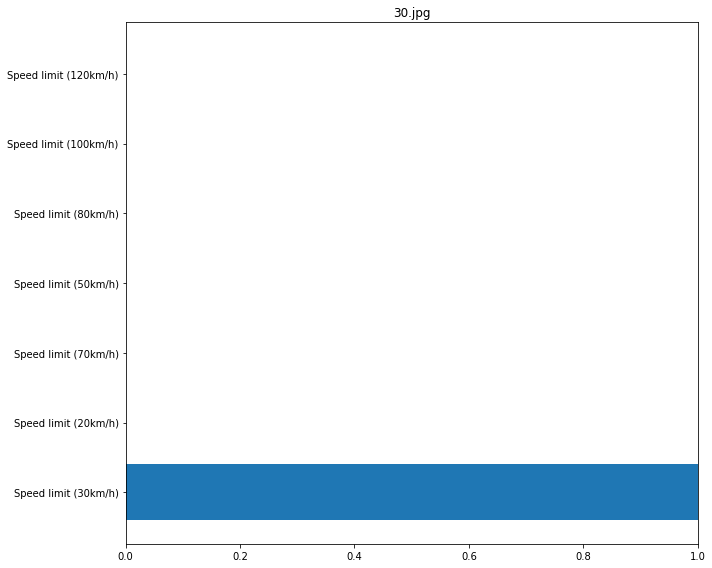

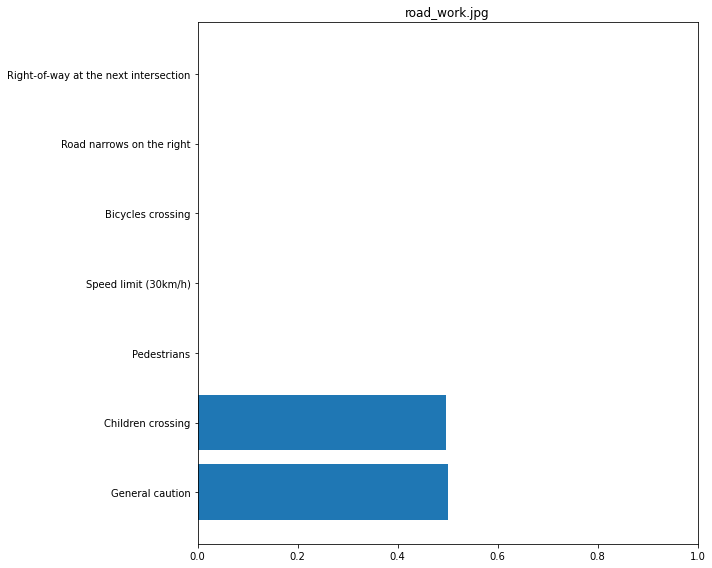

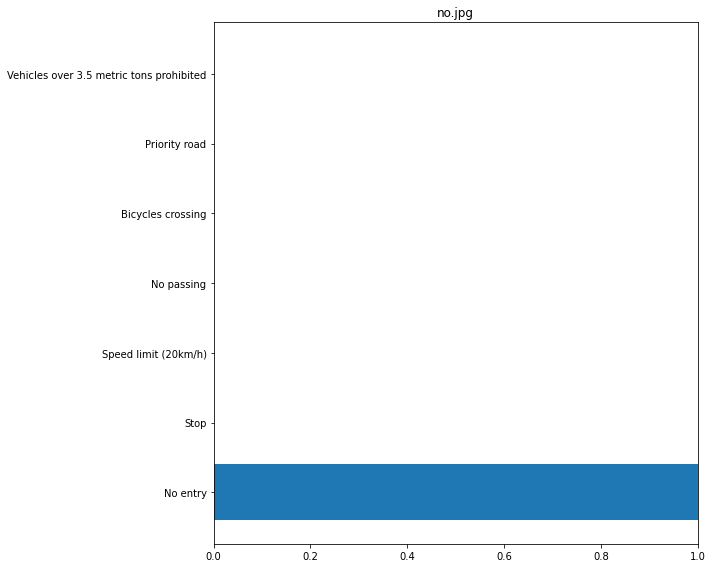

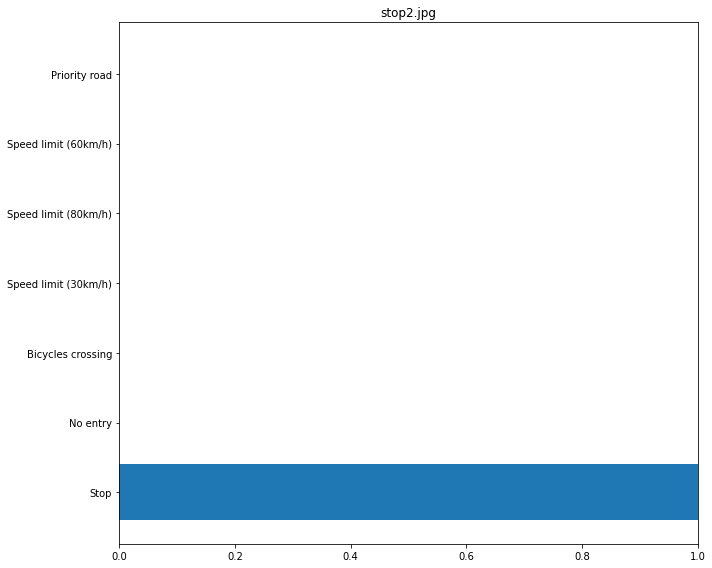

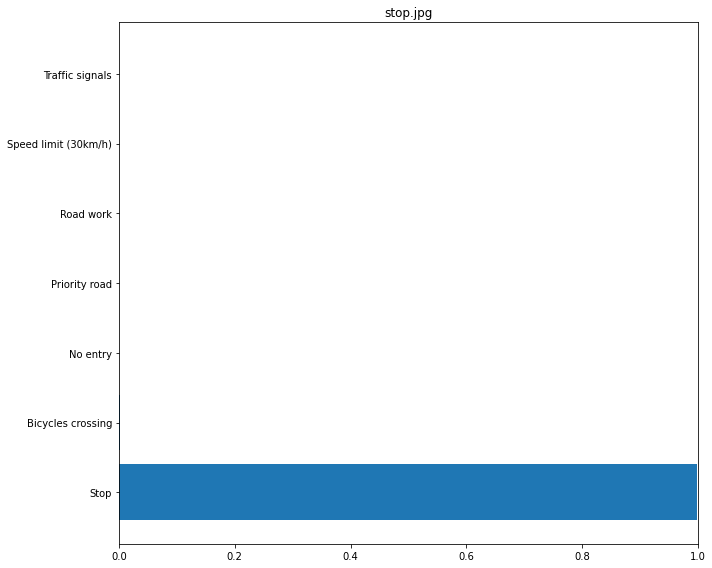

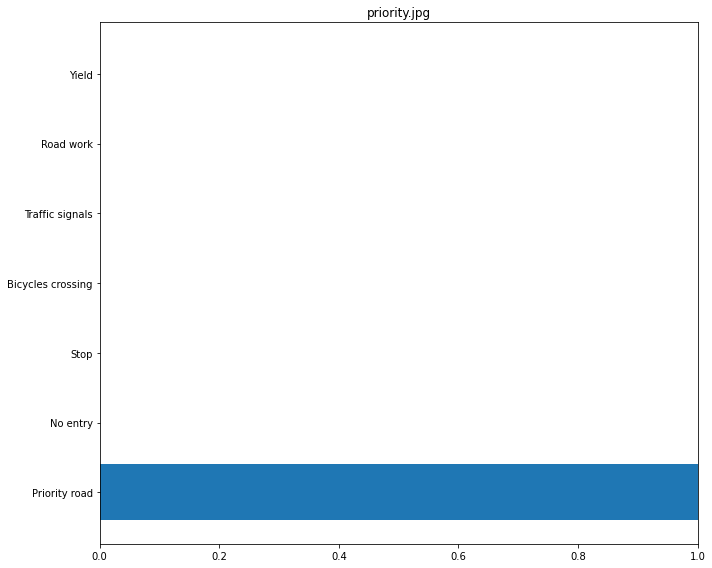

In [25]:
for i in range(len(X_test_new)):
    names = result[1][i][:]
    prob = result[0][i][:]
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    prob_name = []
    for name in names:
        prob_name.append(signs[name])
    ax.barh(prob_name, prob)
    ax.set_yticklabels(prob_name)
    ax.set_title(X_test_new_name[i])
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim([0, 1])
    plt.tight_layout()
    plt.show()


In [ ]:
# HOW TO USE THIS CODE BELOW
# RUN THE HISTOGRAM PLOT FOR TRAIN DATA IF YOU WANT TO AUGMENT THE DATASET BY CHANGING THE POSITION OR ZOOM
# AFTER THAT YOU CAN GO INTO THE NEXT CELL AND CHANGE THE COLORS FOR THE ENTIRE DATASET
# SAVE THE DATASET
# DO THE SAME FOR VALID DATA SET

In [ ]:
import random
print("Classes with less than 500 pictures are: ")
for index,x in enumerate(hist):
    print(index,x)
    print(X_train.shape[0])
    detected = np.where(y_train == index)
    indexs = detected[0]
    if(x > 800 and x < 1100):
        for z in range(indexs[0],indexs[-1]+1):
            num = random.choice([0, 1,2,3])
            img1, img2, img3, img4, img5= create_pictures(X_train[z])
            if num == 0:
                X_train = np.append(X_train,[img1],axis=0)
            if num == 1:
                X_train = np.append(X_train,[img2],axis=0)
            if num == 2:
                X_train = np.append(X_train,[img3],axis=0)
            if num == 3:
                X_train = np.append(X_train,[img4],axis=0)
            y_train = np.append(y_train,[index],axis=0)
    if(x > 1100 and x < 1500):
        for z in range(indexs[0],indexs[-1]+1,2):
            num = random.choice([0, 1,2,3])
            img1, img2, img3,img4, img5 = create_pictures(X_train[z])
            if num == 0:
                X_train = np.append(X_train,[img1],axis=0)
            if num == 1:
                X_train = np.append(X_train,[img2],axis=0)
            if num == 2:
                X_train = np.append(X_train,[img3],axis=0)
            if num == 3:
                X_train = np.append(X_train,[img4],axis=0)
            
            y_train = np.append(y_train,[index],axis=0)
    if(x > 1500 and x < 2000):
        for z in range(indexs[0],indexs[-1]+1,4):
            num = random.choice([0, 1,2,3])
            img1, img2, img3, img4, img5 = create_pictures(X_train[z])
            if num == 0:
                X_train = np.append(X_train,[img1],axis=0)
            if num == 1:
                X_train = np.append(X_train,[img2],axis=0)
            if num == 2:
                X_train = np.append(X_train,[img3],axis=0)
            if num == 3:
                X_train = np.append(X_train,[img4],axis=0)
            
            y_train = np.append(y_train,[index],axis=0)
    if(x > 600 and x < 800):
        for z in range(indexs[0],indexs[-1]+1):
            num1 = random.choice([0, 1,2])
            if num1 != 0:
                num2 = random.choice([0,3])
            else:
                num2 = random.choice([3])
            img1, img2, img3, img4, img5= create_pictures(X_train[z])
            if num1 == 0:
                X_train = np.append(X_train,[img1],axis=0)
            if num1 == 1:
                X_train = np.append(X_train,[img2],axis=0)
            if num1 == 2:
                X_train = np.append(X_train,[img3],axis=0)
            if num2 == 0:
                X_train = np.append(X_train,[img1],axis=0)
            if num2 == 3:
                X_train = np.append(X_train,[img4],axis=0)
            
            y_train = np.append(y_train,[index],axis=0)
            y_train = np.append(y_train,[index],axis=0)
    if(x > 400 and x < 600):
        for z in range(indexs[0],indexs[-1]+1):
            num1 = random.choice([1,2])
            num2 = random.choice([3])
            img1, img2, img3, img4, img5= create_pictures(X_train[z])
            X_train = np.append(X_train,[img1],axis=0)
            y_train = np.append(y_train,[index],axis=0)
            if num1 == 1:
                X_train = np.append(X_train,[img2],axis=0)
            if num1 == 2:
                X_train = np.append(X_train,[img3],axis=0)
            if num2 == 3:
                X_train = np.append(X_train,[img4],axis=0)
            
            y_train = np.append(y_train,[index],axis=0)
            y_train = np.append(y_train,[index],axis=0)
    if(x < 400):
        print(indexs[0],indexs[-1]+1)
        for z in range(indexs[0],indexs[-1]+1):
            img1, img2, img3, img4, img5= create_pictures(X_train[z])
            X_train = np.append(X_train,[img1],axis=0)
            y_train = np.append(y_train,[index],axis=0)
            X_train = np.append(X_train,[img2],axis=0)
            y_train = np.append(y_train,[index],axis=0)
            X_train = np.append(X_train,[img3],axis=0)
            y_train = np.append(y_train,[index],axis=0)
            X_train = np.append(X_train,[img4],axis=0)
            y_train = np.append(y_train,[index],axis=0)
            
            


In [ ]:
ver = 0
contor = 0
for image in X_train:
    if ver % 100 == 0: 
            print("Inca ",ver," poze au fost procesate . Nr total: ", X_train.shape[0])
    value = 60
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    hls[:,:,2] = np.where((255 - hls[:,:,2]) < value,255,hls[:,:,2]+value)
    rgbFromHls = cv2.cvtColor(hls,cv2.COLOR_HLS2RGB)
        
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    value = 100
    hsv[:,:,2] = np.where((255 - hsv[:,:,2]) < value,255,hsv[:,:,2]+value)
    rgbFromHsv = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        
    X_train = np.append(X_train,[rgbFromHls],axis=0)
    y_train = np.append(y_train,[y_train[contor]],axis=0)
    X_train = np.append(X_train,[rgbFromHsv],axis=0)
    y_train = np.append(y_train,[y_train[contor]],axis=0)
    ver = ver + 2    
    contor = contor + 1
  

In [ ]:
filename = 'new_x_train_data_6.p'
outfile = open(filename,'wb')
pickle.dump(X_train,outfile)
outfile.close()
filename = 'new_y_train_data_6.p'
outfile = open(filename,'wb')
pickle.dump(y_train,outfile)
outfile.close()

In [ ]:
import random
print("Classes with less than 500 pictures are: ")
for index,x in enumerate(hist):
    print(index,x)
    print(X_valid.shape[0])
    detected = np.where(y_valid == index)
    indexs = detected[0]
    if(x > 150 and x < 200):
        for z in range(indexs[0],indexs[-1]+1,2):
            num = random.choice([0, 1,2,3])
            img1, img2, img3, img4, img5= create_pictures(X_valid[z])
            if num == 0:
                X_valid = np.append(X_valid,[img1],axis=0)
            if num == 1:
                X_valid = np.append(X_valid,[img2],axis=0)
            if num == 2:
                X_valid = np.append(X_valid,[img3],axis=0)
            if num == 3:
                X_valid = np.append(X_valid,[img4],axis=0)
            
            y_valid = np.append(y_valid,[index],axis=0)
    if(x > 110 and x < 150):
        for z in range(indexs[0],indexs[-1]+1):
            num = random.choice([0, 1,2,3])
            img1, img2, img3,img4, img5 = create_pictures(X_valid[z])
            if num == 0:
                X_valid = np.append(X_valid,[img1],axis=0)
            if num == 1:
                X_valid = np.append(X_valid,[img2],axis=0)
            if num == 2:
                X_valid = np.append(X_valid,[img3],axis=0)
            if num == 3:
                X_valid = np.append(X_valid,[img4],axis=0)
            
            y_valid = np.append(y_valid,[index],axis=0)
    if(x > 200 and x < 250):
        for z in range(indexs[0],indexs[-1]+1,4):
            num = random.choice([0, 1,2,3])
            img1, img2, img3, img4, img5 = create_pictures(X_valid[z])
            if num == 0:
                X_valid = np.append(X_valid,[img1],axis=0)
            if num == 1:
                X_valid = np.append(X_valid,[img2],axis=0)
            if num == 2:
                X_valid = np.append(X_valid,[img3],axis=0)
            if num == 3:
                X_valid = np.append(X_valid,[img4],axis=0)
            
            y_valid = np.append(y_valid,[index],axis=0)
    if(x > 70 and x < 110):
        for z in range(indexs[0],indexs[-1]+1):
            num1 = random.choice([0, 1,2])
            if num1 != 0:
                num2 = random.choice([0,3])
            else:
                num2 = random.choice([3])
            img1, img2, img3, img4, img5= create_pictures(X_valid[z])
            if num1 == 0:
                X_valid = np.append(X_valid,[img1],axis=0)
            if num1 == 1:
                X_valid = np.append(X_valid,[img2],axis=0)
            if num1 == 2:
                X_valid = np.append(X_valid,[img3],axis=0)
            if num2 == 0:
                X_valid = np.append(X_valid,[img1],axis=0)
            if num2 == 3:
                X_valid = np.append(X_valid,[img4],axis=0)
            
            y_valid = np.append(y_valid,[index],axis=0)
            y_valid = np.append(y_valid,[index],axis=0)
    if(x > 40 and x < 70):
        for z in range(indexs[0],indexs[-1]+1):
            num1 = random.choice([1,2])
            num2 = random.choice([3])
            img1, img2, img3, img4, img5= create_pictures(X_valid[z])
            X_valid = np.append(X_valid,[img1],axis=0)
            y_valid = np.append(y_valid,[index],axis=0)
            if num1 == 1:
                X_valid = np.append(X_valid,[img2],axis=0)
            if num1 == 2:
                X_valid = np.append(X_valid,[img3],axis=0)
            if num2 == 3:
                X_valid = np.append(X_valid,[img4],axis=0)
            
            y_valid = np.append(y_valid,[index],axis=0)
            y_valid = np.append(y_valid,[index],axis=0)
    if(x < 40):
        print(indexs[0],indexs[-1]+1)
        for z in range(indexs[0],indexs[-1]+1):
            img1, img2, img3, img4, img5= create_pictures(X_valid[z])
            X_valid = np.append(X_valid,[img1],axis=0)
            y_valid = np.append(y_valid,[index],axis=0)
            X_valid = np.append(X_valid,[img2],axis=0)
            y_valid = np.append(y_valid,[index],axis=0)
            X_valid = np.append(X_valid,[img3],axis=0)
            y_valid = np.append(y_valid,[index],axis=0)
            X_valid = np.append(X_valid,[img4],axis=0)
            y_valid = np.append(y_valid,[index],axis=0)
            
            


In [ ]:
ver = 0
contor = 0
for image in X_valid:
    if ver % 100 == 0: 
            print("Inca ",ver," poze au fost procesate . Nr total: ", X_valid.shape[0])
    value = 60
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    hls[:,:,2] = np.where((255 - hls[:,:,2]) < value,255,hls[:,:,2]+value)
    rgbFromHls = cv2.cvtColor(hls,cv2.COLOR_HLS2RGB)
        
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    value = 100
    hsv[:,:,2] = np.where((255 - hsv[:,:,2]) < value,255,hsv[:,:,2]+value)
    rgbFromHsv = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        
    X_valid = np.append(X_valid,[rgbFromHls],axis=0)
    y_valid = np.append(y_valid,[y_valid[contor]],axis=0)
    X_valid = np.append(X_valid,[rgbFromHsv],axis=0)
    y_valid = np.append(y_valid,[y_valid[contor]],axis=0)
    ver = ver + 2    
    contor = contor + 1
  


In [ ]:
filename = 'new_x_valid_data_6.p'
outfile = open(filename,'wb')
pickle.dump(X_valid,outfile)
outfile.close()
filename = 'new_y_valid_data_6.p'
outfile = open(filename,'wb')
pickle.dump(y_valid,outfile)
outfile.close()